In [1]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.LISTA import LISTA, LISTA_Net
from models.LISTA_CPSS import LISTA_CPSS
from models.TiLISTA import TiLISTA
from models.ALISTA import ALISTA

from utils.ISTA_FISTA import *
from utils.train import train, layerwise_train
from utils.synthetic_data import SyntheticSignals

In [3]:
torch.cuda.is_available()

True

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [4]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 4000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 1000
    ).set_loader()

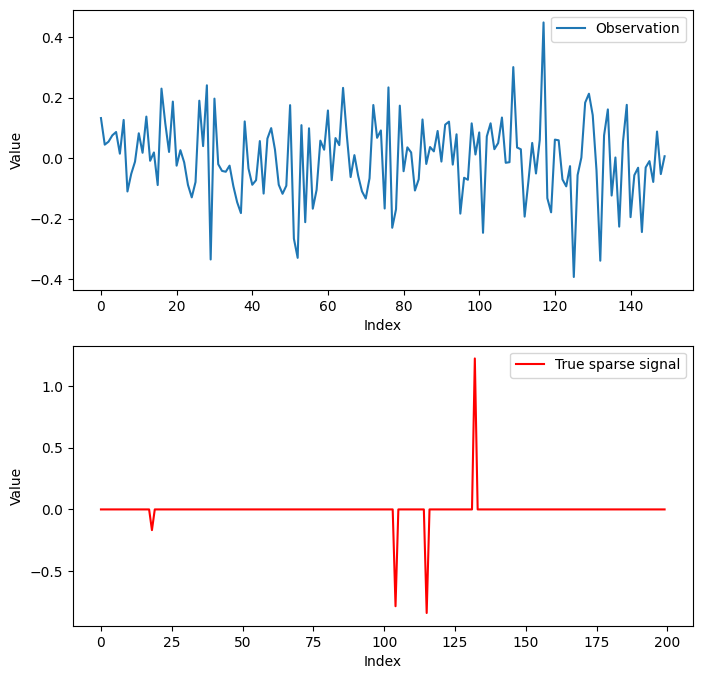

In [5]:
x_exm, s_exm =test_set.dataset.__getitem__(20)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

### Comparing ISTA and LISTA

In [ ]:
M = 50
LAYERS = 5
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

ISTA_LOSS = np.zeros((M, 100))
FISTA_LOSS = np.zeros((M, 100))
LISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 1000
        ).set_loader()
    
    model = LISTA_Net(torch.clone(A_), 0.4, 5)
    loss = train(model, train_set, test_set, num_epochs=50, verbose = False)
    
    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, 100, A_, rho = 0.4)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, 100, A_, rho = 0.4)
    LISTA_LOSS[m,:] = model.compute_nmse_inference(test_set)

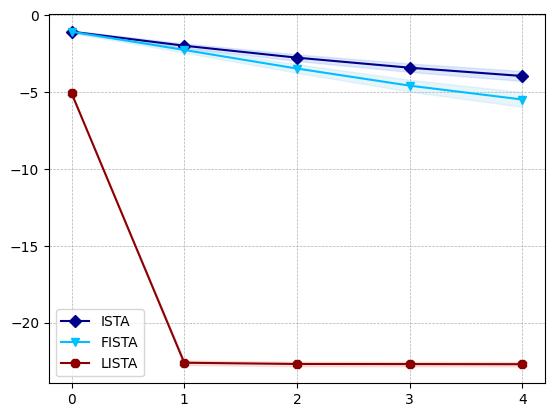

In [16]:
plt.plot(np.mean(ISTA_LOSS, axis = 0)[0:LAYERS], label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0)[0:LAYERS], label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                color='skyblue', 
                alpha=0.2)

plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Comparing different variations of the LISTA architecture

In [4]:
SNRs = [None, 40, 30, 20]

inference_errors = {
    'NOISELESS': {
        'LISTA': None,
        'LISTA-CPSS':None,
        'TILISTA': None,
        'ALISTA':None
    },
    40: {
        'LISTA': None,
        'LISTA-CPSS':None,
        'TILISTA': None,
        'ALISTA':None
    },
    30: {
        'LISTA': None,
        'LISTA-CPSS':None,
        'TILISTA': None,
        'ALISTA':None
    },
    20: {
        'LISTA': None,
        'LISTA-CPSS':None,
        'TILISTA': None,
        'ALISTA':None
    }
}

LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50

n_ = 500
m_ = 250
p_ = 0.1

torch.manual_seed(42)

# Sensing matrix
A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Dimensions for the signal, its sparsity and its observation
for SNR in tqdm(SNRs):

    if SNR is None:
        key = 'NOISELESS'
    else:
        key = SNR

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 10**(SNR/10) if SNR is not None else None,
        size = 10000,
        batch_size=1000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 10**(SNR/10) if SNR is not None else None,
        size = 1000
        ).set_loader()

    model1 = LISTA(torch.clone(A_), BETA_INIT, LAYERS)
    layerwise_train(model1, train_set, test_set, lr = 3e-3, ft_lr = 3e-5, model_class='LISTA', verbose=False)

    model2 = LISTA_CPSS(torch.clone(A_), BETA_INIT, LAYERS)
    layerwise_train(model2, train_set, test_set, lr = 3e-3,  ft_lr = 3e-5, model_class='LISTA-CPSS', verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    layerwise_train(model3, train_set, test_set, lr = 3e-3,  ft_lr = 3e-5, model_class='TILISTA', verbose=False)

    model4 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    layerwise_train(model4, train_set, test_set, lr = 3e-3,  ft_lr = 3e-5, model_class='ALISTA', verbose=False)

    inference_errors[key]['LISTA'] = model1.compute_nmse_inference(test_set).cpu().numpy()
    inference_errors[key]['LISTA-CPSS'] = model2.compute_nmse_inference(test_set).cpu().numpy()
    inference_errors[key]['TILISTA'] = model3.compute_nmse_inference(test_set).cpu().numpy()
    inference_errors[key]['ALISTA'] = model4.compute_nmse_inference(test_set).cpu().numpy()

    inference_errors[key]['ISTA'] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    inference_errors[key]['FISTA'] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

  0%|          | 0/4 [00:00<?, ?it/s]

Linear layer initialized minimizing coherence!


 25%|██▌       | 1/4 [45:11<2:15:33, 2711.28s/it]

Linear layer initialized minimizing coherence!


 50%|█████     | 2/4 [1:18:33<1:16:27, 2293.98s/it]

Linear layer initialized minimizing coherence!


 75%|███████▌  | 3/4 [1:46:27<33:30, 2010.84s/it]  

Linear layer initialized minimizing coherence!


100%|██████████| 4/4 [2:10:33<00:00, 1958.43s/it]


In [13]:
with open('ISTA_LISTA.pkl', 'wb') as handle:
    pickle.dump(inference_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

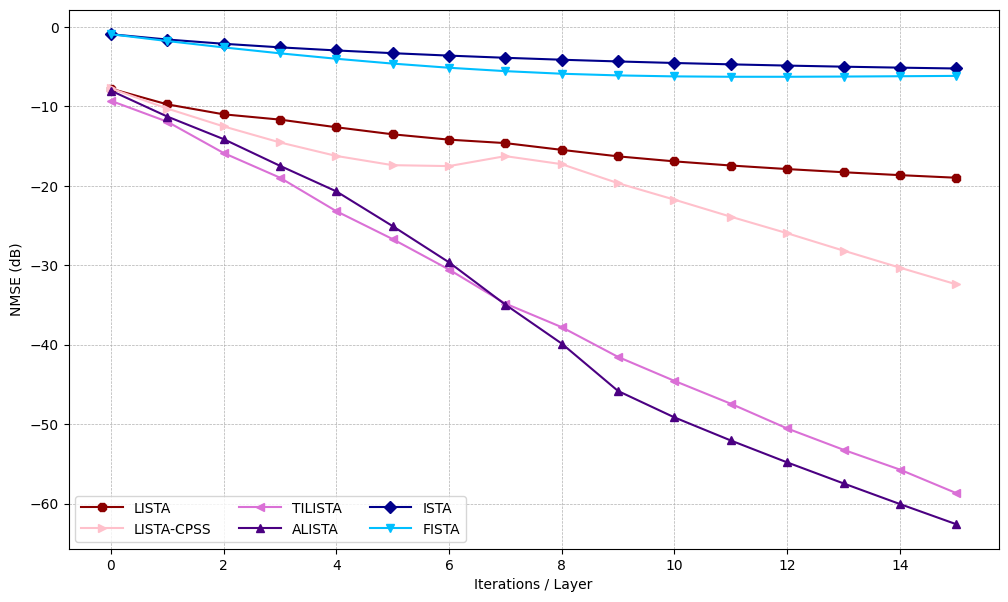

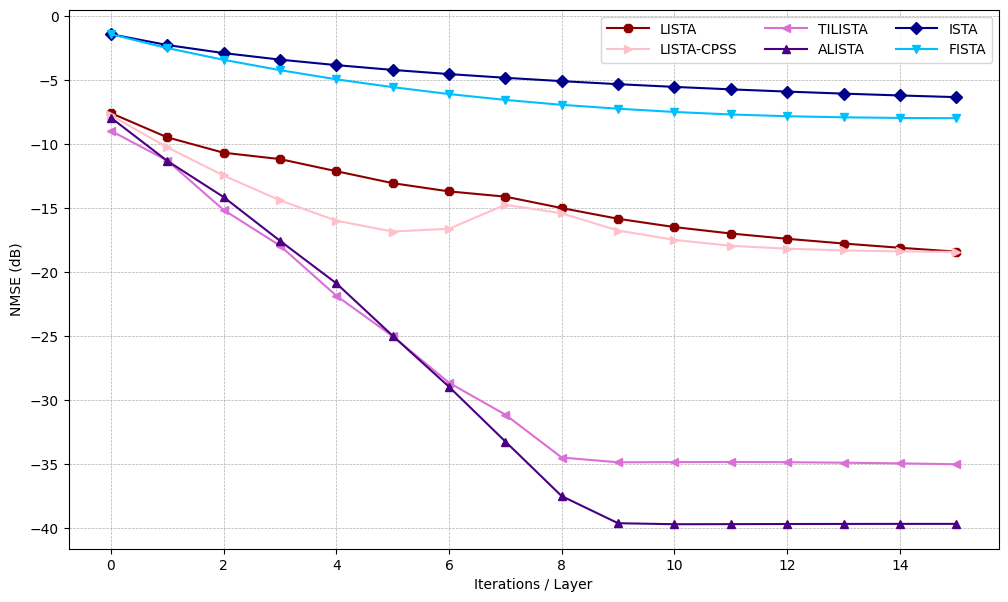

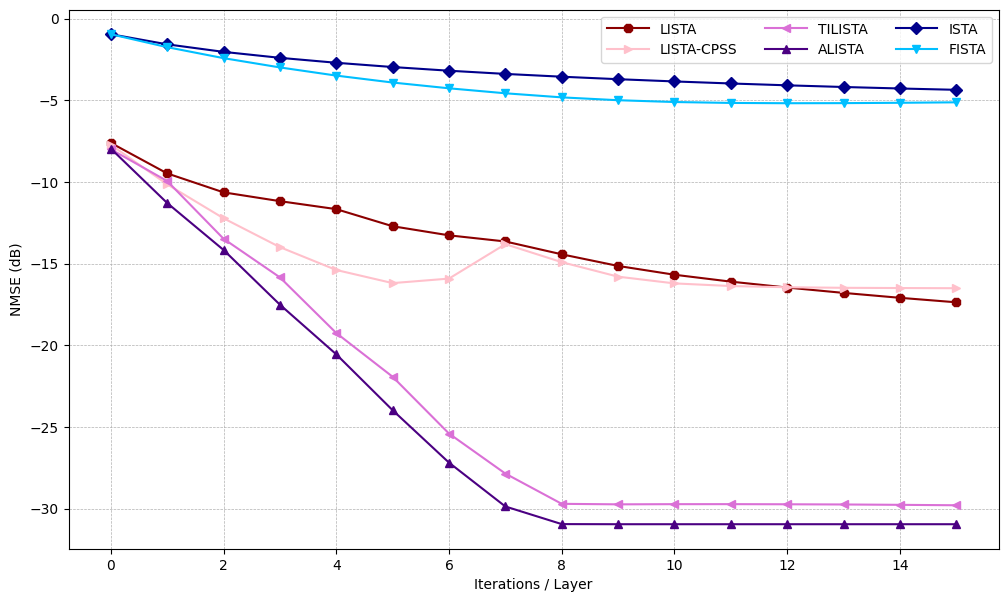

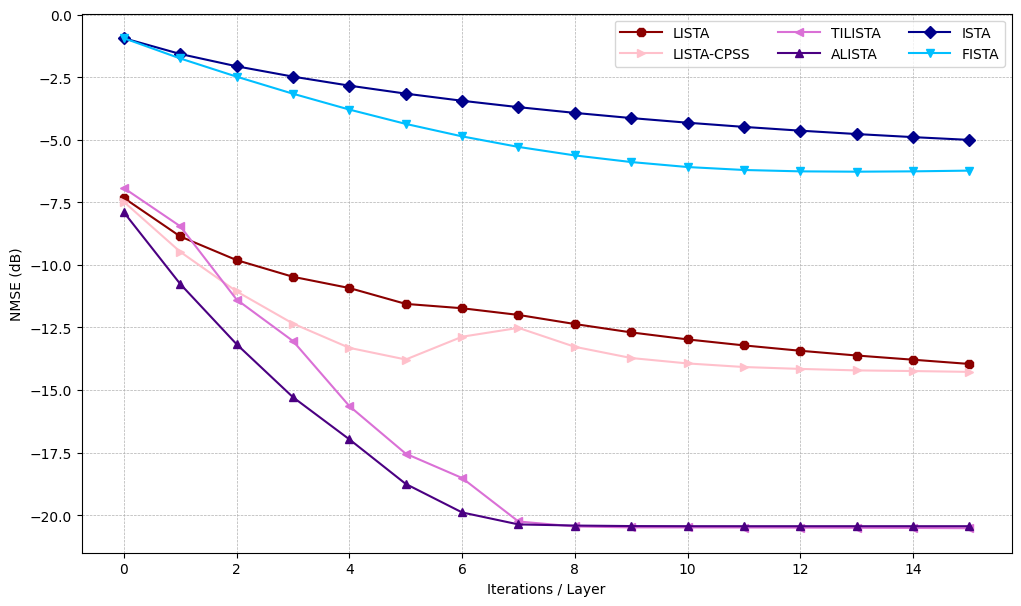

In [5]:
SNRs = ['NOISELESS', 40, 30, 20]

legend = True
for SNR in SNRs:
    plt.figure(figsize=(12,7))
    
    plt.plot(inference_errors[SNR]['LISTA'], label='LISTA', color='#8B0000', marker = '8')

    plt.plot(inference_errors[SNR]['LISTA-CPSS'], label='LISTA-CPSS', color='pink', marker = '>')

    plt.plot(inference_errors[SNR]['TILISTA'], label='TILISTA', color='orchid', marker = '<')

    plt.plot(inference_errors[SNR]['ALISTA'], label='ALISTA', color='indigo', marker = '^')

    plt.plot(inference_errors[SNR]['ISTA'], label='ISTA', color='darkblue', marker = 'D')

    plt.plot(inference_errors[SNR]['FISTA'], label='FISTA', color='deepskyblue', marker = 'v')

    plt.xticks(range(LAYERS))

    plt.ylabel('NMSE (dB)')
    plt.xlabel('Iterations / Layer')

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.grid(True, which="both", ls="--", linewidth=0.5)

    if legend:

        plt.legend(handlelength=3, loc='lower left', fancybox=True, ncol = 3, frameon=True)
        legend = False
    
    else:
        plt.legend(handlelength=3, loc='upper right', fancybox=True, ncol = 3, frameon=True)


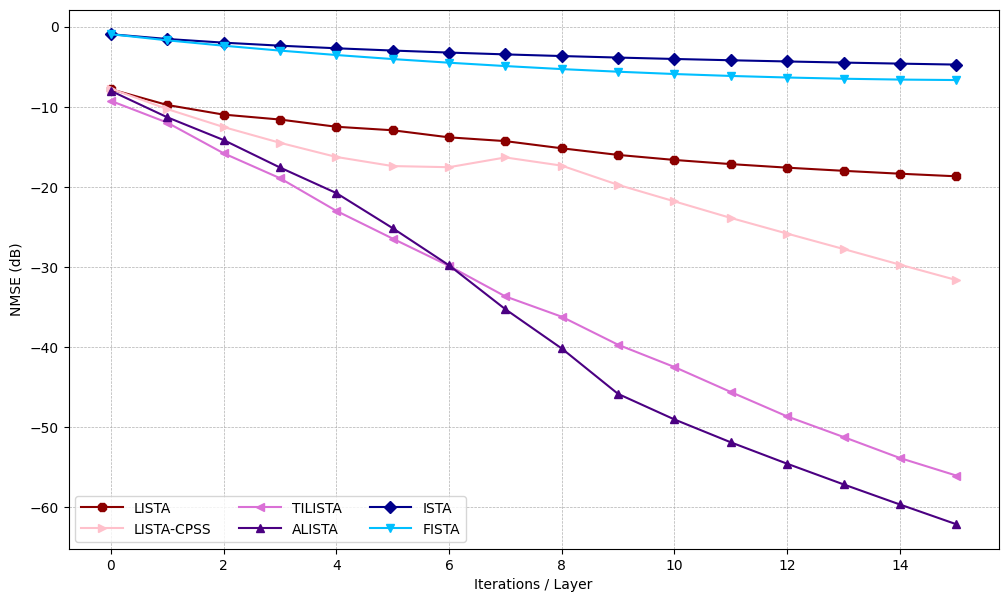

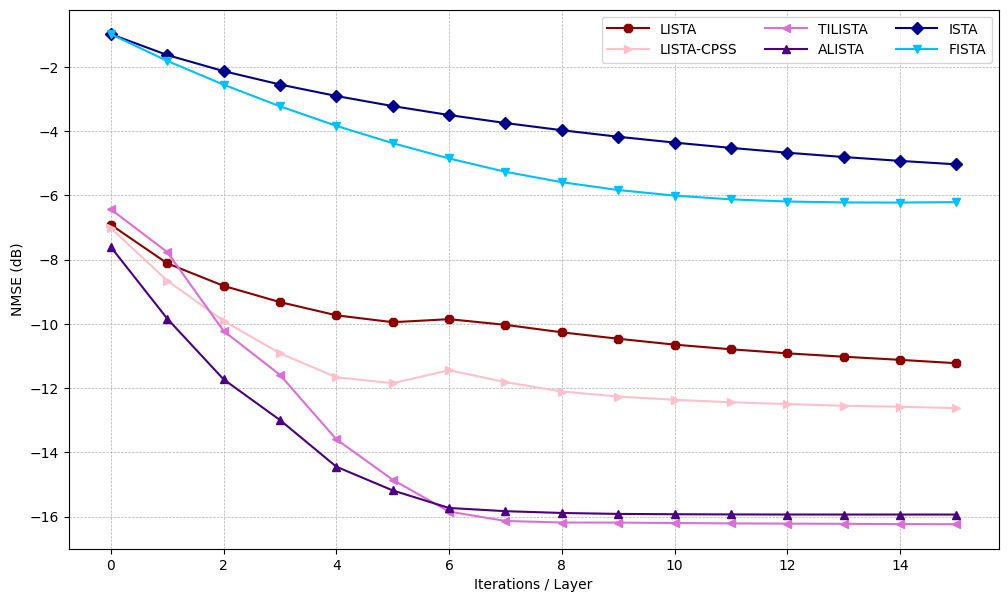

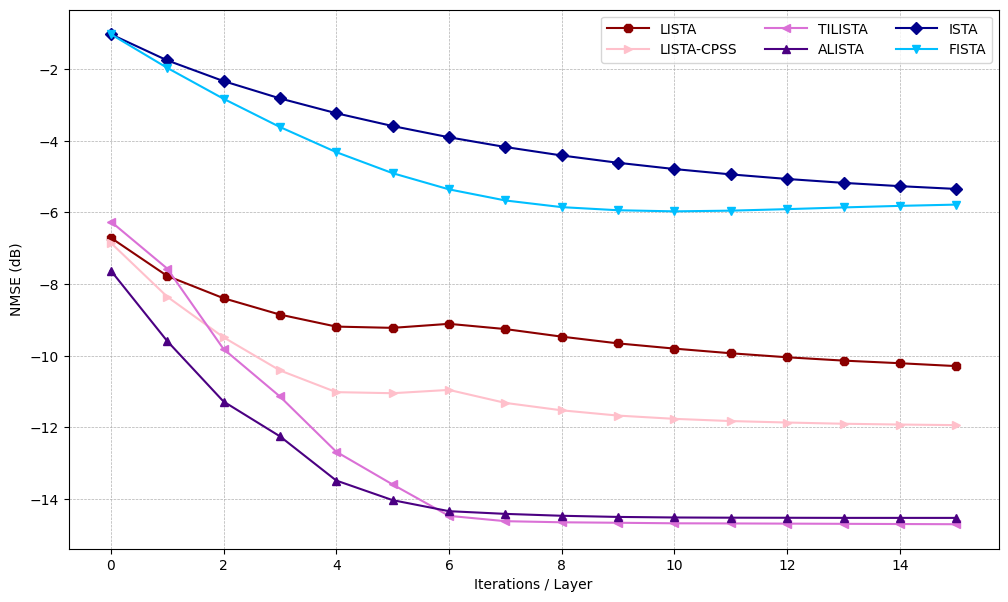

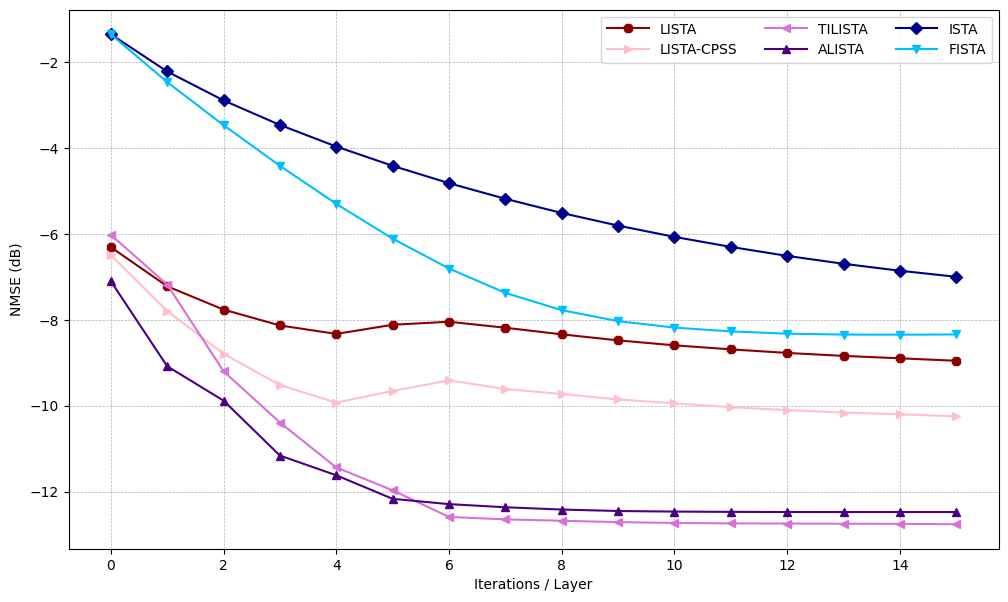

In [11]:
SNRs = ['NOISELESS', 40, 30, 20]

legend = True
for SNR in SNRs:
    plt.figure(figsize=(12,7))
    
    plt.plot(inference_errors[SNR]['LISTA'], label='LISTA', color='#8B0000', marker = '8')

    plt.plot(inference_errors[SNR]['LISTA-CPSS'], label='LISTA-CPSS', color='pink', marker = '>')

    plt.plot(inference_errors[SNR]['TILISTA'], label='TILISTA', color='orchid', marker = '<')

    plt.plot(inference_errors[SNR]['ALISTA'], label='ALISTA', color='indigo', marker = '^')

    plt.plot(inference_errors[SNR]['ISTA'], label='ISTA', color='darkblue', marker = 'D')

    plt.plot(inference_errors[SNR]['FISTA'], label='FISTA', color='deepskyblue', marker = 'v')

    plt.xticks(range(LAYERS))

    plt.ylabel('NMSE (dB)')
    plt.xlabel('Iterations / Layer')

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.grid(True, which="both", ls="--", linewidth=0.5)

    if legend:

        plt.legend(handlelength=3, loc='lower left', fancybox=True, ncol = 3, frameon=True)
        legend = False
    
    else:
        plt.legend(handlelength=3, loc='upper right', fancybox=True, ncol = 3, frameon=True)


In [6]:
inference_errors

{'NOISELESS': {'LISTA': array([ -8.89773 , -10.691065, -11.429347, -12.4273  , -13.09799 ,
         -14.640549, -15.443291, -16.177654, -17.137606, -17.990562,
         -18.630692, -19.164333, -19.63041 , -20.04306 , -20.42512 ,
         -20.77262 ], dtype=float32),
  'LISTA-CPSS': array([ -8.0993805,  -9.569187 , -11.238867 , -12.854166 , -14.498458 ,
         -15.936876 , -17.038687 , -17.581388 , -18.995987 , -20.883575 ,
         -22.527296 , -24.17458  , -25.860521 , -27.535341 , -29.261612 ,
         -30.998756 ], dtype=float32),
  'TILISTA': array([ -9.291315, -11.126396, -15.205617, -17.032644, -20.266266,
         -22.19685 , -23.952396, -26.071838, -28.254766, -31.010452,
         -33.584164, -35.86803 , -38.52949 , -40.70723 , -43.545135,
         -45.735374], dtype=float32),
  'ALISTA': array([ -8.6339035, -10.387991 , -12.4317665, -14.744024 , -17.406443 ,
         -20.262444 , -23.774052 , -27.837755 , -32.062492 , -35.290993 ,
         -37.96105  , -40.4904   , -42.96833